# Packages 

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from math import *
from sklearn.metrics import r2_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline
from tqdm import tqdm
import csv as csv

# Preliminary information

This script allows you the process raw PCR data by ddCT method. You first need to label all your conditions through Platypus GUI to get a label dataframe, converted in csv file.

Then, you need to define your path, experiment name, file name, and the number of plate if you have several plates.

You also need to define the method you want to use to normalize your data in the ddCT process. The default method use sthe mean of all untreated conditions, whatever conditions. You can also choose by writting on the cell below if you want to use one of the two other methods ;
    - global_minimal_value: it takes the minimal value of dCT amoung all your untreated samples
    - condition_minimal_value: it chooses the condition with the minimal mean between your samples amoug untreated conditions 

In [ ]:
output_path = '/Users/lanauaa/Desktop/Viral_dynamics_project/Data_replication_immunotron/'
experiment_name = '20230306_MHV_HeLa_kinetics'
name_rawdata_file = '20230202_MHV_HeLa_sybr_plate'
plate_number='3'
normalizing_method='default' # other possibilities: global_minimal_value or condition_minimal_value

In [21]:
data = pd.read_csv('/Users/lanauaa/Desktop/Viral_dynamics_project/Data_replication_hand/20230425_CVB_HeLa_kinetics_12h_Exp5/Data/050123 qalga_sybr_cvb gapdh tm54 - Abs Quant.txt',sep='\t').drop(['Color','Sample Name','Concentration','Standard','Number','Sample Prep Notes','Notes','Failure','EPF','Slope','Edited Call','Replicate Group','Concentration Error','Dye','Concentration Mean','Cq Error','Excluded','Call','Gene Name','Cq Mean','Sample Type'],axis=1).dropna(axis=0,inplace=False)
data
data.to_csv('/Users/lanauaa/Desktop/Viral_dynamics_project/Data_replication_hand/20230425_CVB_HeLa_kinetics_12h_Exp5/Data/050123 qalga_sybr_cvb gapdh tm54 - Abs Quant.csv')

# Process

In [1]:
#Convert txt to csv
# convertion_to_csv = pd.read_csv('{}/{}/Data/{}{}.txt'.format(output_path,experiment_name,name_rawdata_file,plate_number),sep='\t')
# convertion_to_csv.drop(['Include','Name','Concentration','Standard','Status'], axis=1,inplace=True)
# convertion_to_csv.to_csv('{}/{}/Data/{}{}.csv'.format(output_path,experiment_name,name_rawdata_file,plate_number))

#Import data
# pcr_data_raw = pd.read_csv('{}/{}/Data/{}{}.csv'.format(output_path,experiment_name,name_rawdata_file,plate_number)).drop(['Unnamed: 0'],axis=1).rename(columns={'Pos':'Tag','Cp':'CT'})               
# pcr_data = pcr_data_raw.dropna(axis=0, inplace=False)  

pcr_data_raw = pd.read_csv('/Users/lanauaa/Desktop/Viral_dynamics_project/Data_replication_hand/20230425_CVB_HeLa_kinetics_12h_Exp5/Data/CVB EXP5-042523 ALGA 12H KINETIC_TECHNIQUE_1.csv').rename(columns={'Pos':'Tag','Cp':'CT'})             
pcr_data = pcr_data_raw.dropna(axis=0, inplace=False).set_index(['Titer','Timepoint','GeneType','Technical_Replicate','PCR_Replicate']).drop('Unnamed: 0', axis=1) 
#delta2CT method
#mean replicate 

levels=pcr_data.reset_index(level='PCR_Replicate').index.names #--> when we get multi index labelling from platypus
print(levels)
# levels.drop(['PCR_Replicate'],axis=0)
pcr_mean_data=pcr_data.groupby(by=levels).mean()
print(pcr_mean_data)

#dCT
goi_list=pcr_mean_data.index.get_level_values(level='GeneType').unique().drop('HK')
pcr_mean_2_data=pcr_mean_data.unstack(level='GeneType')
print(pcr_mean_2_data)
for goi in goi_list:
    pcr_mean_2_data['dCT'] = pcr_mean_2_data['CT',goi] - pcr_mean_2_data['CT','HK']


#ddCT
if normalizing_method=='global_minimal_value':
    DeltaCT_min=min(pcr_mean_2_data.query('Titer==0')['dCT'])
    print(DeltaCT_min)
# else if normalizing_method=='condition_minimal_value':
    # DeltaCT_min=min(
else:
    DeltaCT_min=pcr_mean_2_data.query('Titer==0')['dCT'].mean() #Baseline definition, could introduce several option, to be continued
    
pcr_mean_2_data['ddCT']=pcr_mean_2_data['dCT']-DeltaCT_min

#Gene expression
pcr_mean_2_data['GeneExpression']=2**(-pcr_mean_2_data['ddCT'])
print(pcr_mean_2_data)


# quality control 
a = sns.relplot(data=pcr_mean_2_data,
                # hue='Timepoint',
                x="Titer",y=pcr_mean_2_data['CT','HK'],
                col="Timepoint",
                col_wrap=4,
                kind='scatter',
                # palette='RdPu',
                color='k',
                ci=0.95)

colors_list = sns.color_palette('RdPu',n_colors=len(pcr_mean_2_data.index.get_level_values(level='Timepoint').unique()))
params_list = pcr_mean_2_data.index.unique('Timepoint').tolist()
for i,timepoint in enumerate(params_list):
            timepointDf = pcr_mean_2_data.query("Timepoint == @timepoint")['CT','HK']
            mean_hk = np.mean(timepointDf)
            ax=a.axes.flat[i]
            ax.axhline(y=mean_hk,color=colors_list[i])
            ax.axhline(y=mean_hk-1,ls='--',color=colors_list[i])
            ax.axhline(y=mean_hk+1,ls='--',color=colors_list[i])
            ax.set_title(f'Housekeeping gene quality control - {params_list[i]}h')
a.set(xscale='log',ylabel='CT of Housekeeping Gene')
plt.show()

g = sns.lineplot(data=pcr_mean_2_data,
                 hue='Timepoint',
                 x='Titer',
                 y=pcr_mean_2_data['CT','HK'],
                 palette='RdPu')
g.set(xscale='log',title='Housekeeping gene quality control',ylabel='CT of Housekeeping Gene')
g.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

# PCR_data_mean.sort_values(['Titer','Timepoint'],inplace=True)
# PCR_data_mean.to_csv('{}/{}/Data/Analyzed_PCR_Data_Plate_{}.csv'.format(output_path,experiment_name,plate_number))

pcr_mean_2_data

NameError: name 'pd' is not defined

In [ ]:
#Convert txt to csv
convertion_to_csv = pd.read_csv('/Users/lanauaa/Desktop/Viral_dynamics_project/Data_replication_hand/20230425_CVB_HeLa_kinetics_12h_Exp5/Data/CVB EXP5-042523 ALGA 12H KINETIC_TECHNIQUE_2.txt',sep='\t')
# convertion_to_csv.drop(['Include','Name','Concentration','Standard','Status'], axis=1,inplace=True)
convertion_to_csv.to_csv('/Users/lanauaa/Desktop/Viral_dynamics_project/Data_replication_hand/20230425_CVB_HeLa_kinetics_12h_Exp5/Data/CVB EXP5-042523 ALGA 12H KINETIC_TECHNIQUE_2.csv')

# GUI

2023-05-02 16:48:55.125 python[23043:2312197] +[CATransaction synchronize] called within transaction


                                                            Unnamed: 0  \
Titer Timepoint GeneType Technical_Replicate PCR_Replicate               
10    3         HK       1                   Rep1                    0   
                         2                   Rep1                    1   
      6         HK       1                   Rep1                    2   
                         2                   Rep1                    3   
      12        HK       1                   Rep1                    4   
                         2                   Rep1                    5   
      3         GOI      1                   Rep1                    6   
                         2                   Rep1                    7   
      6         GOI      1                   Rep1                    8   
                         2                   Rep1                    9   
      12        GOI      1                   Rep1                   10   
                         2            

2023-05-02 16:48:58.342 python[23043:2312197] +[CATransaction synchronize] called within transaction


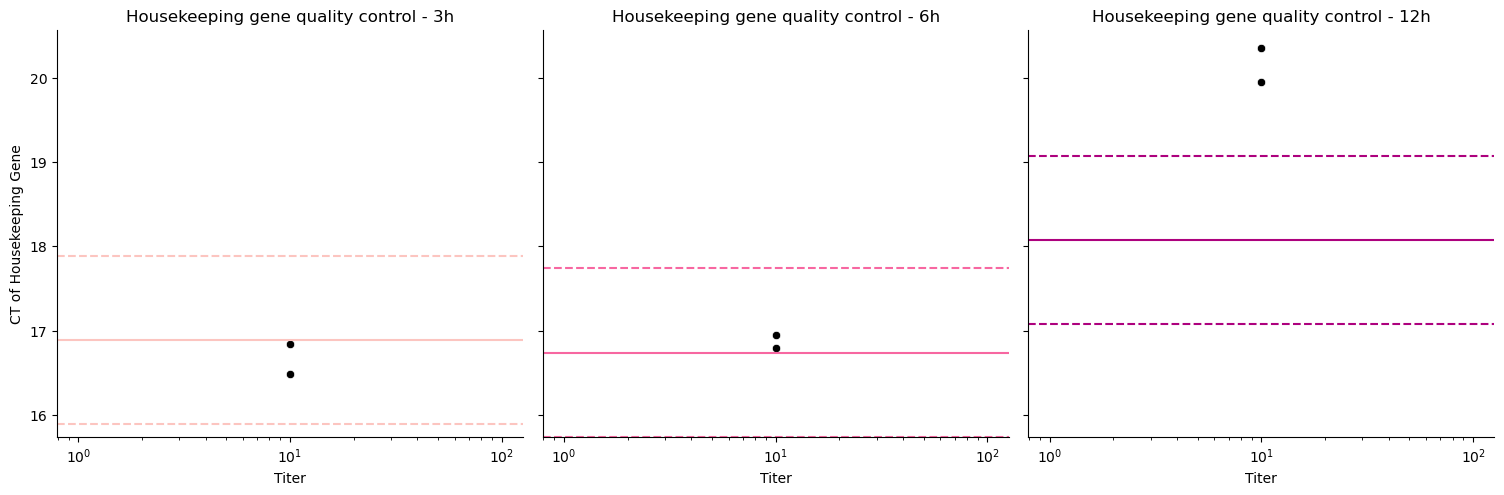

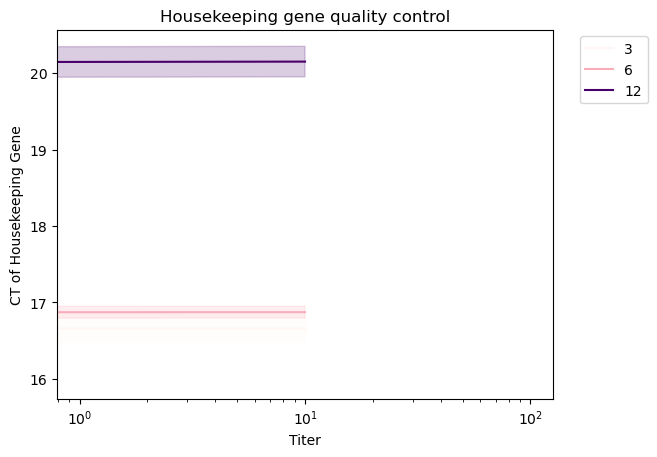

In [24]:
import tkinter as tk
import pandas as pd
from tkinter import filedialog

class PCR_Analyzer_GUI:
    def __init__(self, master):
        self.master = master
        master.title("PCR Data Analysis")
        
        # create label for file path
        self.label_file_path = tk.Label(master, text="File Path:")
        self.label_file_path.grid(row=0, column=0, padx=5, pady=5)
        
        # create entry for file path
        self.entry_file_path = tk.Entry(master)
        self.entry_file_path.grid(row=0, column=1, padx=5, pady=5)
        
        # create button to browse for file
        self.button_browse_file = tk.Button(master, text="Browse", command=self.browse_file)
        self.button_browse_file.grid(row=0, column=2, padx=5, pady=5)
        
        # create dropdown menu for normalization method
        self.norm_method_options = ["Average of UNT samples","Minimum value amoung UNT samples", "Minimum value among the averages of  all conditions for UNT samples "]
        self.norm_method_var = tk.StringVar()
        self.norm_method_dropdown = tk.OptionMenu(master, self.norm_method_var, *self.norm_method_options)
        self.norm_method_dropdown.grid(row=1, column=1, padx=5, pady=5)
        self.norm_method_var.set(self.norm_method_options[0])
        self.norm_method_dropdown = tk.Label(master, text="Normalization method")
        self.norm_method_dropdown.grid(row=1, column=0, padx=5, pady=5)
        
        
        # create button to run script
        self.button_run_script = tk.Button(master, text="Run Script", command=self.run_script)
        self.button_run_script.grid(row=2, column=0, columnspan=3, padx=5, pady=5)
        
    def browse_file(self):
        # open file dialog box to select file
        file_path = filedialog.askopenfilename()
        
        # update entry with selected file path
        self.entry_file_path.delete(0, tk.END)
        self.entry_file_path.insert(0, file_path)
        
    def run_script(self):
        # get file path from entry
        file_path = self.entry_file_path.get()
        
        # get normalization method from dropdown
        normalizing_method = self.norm_method_var.get().replace(" ", "_").lower()

        
        # run script with provided file path
        pcr_data_raw = pd.read_csv(file_path).rename(columns={'Pos':'Tag','Cq':'CT'})
        pcr_data = pcr_data_raw.dropna(axis=0, inplace=False).set_index(['Titer','Timepoint','GeneType','Technical_Replicate','PCR_Replicate']) 
        print(pcr_data)
        levels=pcr_data.reset_index(level='PCR_Replicate').index.names #--> when we get multi index labelling from platypus
        pcr_mean_data=pcr_data.groupby(by=levels).mean()
        
        # dCT
        goi_list=pcr_mean_data.index.get_level_values(level='GeneType').unique().drop('HK')
        pcr_mean_2_data=pcr_mean_data.unstack(level='GeneType')
        for goi in goi_list:
            pcr_mean_2_data['dCT'] = pcr_mean_2_data['CT',goi] - pcr_mean_2_data['CT','HK']


        # ddCT
        # normalization option
        if normalizing_method=='global_minimal_value':
            DeltaCT_min=min(pcr_mean_2_data.query('Titer==0')['dCT'])
        # else if normalizing_method=='condition_minimal_value':
            # DeltaCT_min=min(
        else:
            DeltaCT_min=pcr_mean_2_data.query('Titer==0')['dCT'].mean() # baseline definition, could introduce several option, to be continued
        
        pcr_mean_2_data['ddCT']=pcr_mean_2_data['dCT']-DeltaCT_min

        # gene expression
        pcr_mean_2_data['GeneExpression']=2**(-pcr_mean_2_data['ddCT'])
        pcr_mean_2_data.sort_values(['Titer','Timepoint'],inplace=True)
        
        
        # open file dialog box to select output file path
        output_path = filedialog.asksaveasfilename()
        
        # quality control plot
        a = sns.relplot(data=pcr_mean_2_data,
                x="Titer",y=pcr_mean_2_data['CT','HK'],
                col="Timepoint",
                col_wrap=4,
                kind='scatter',
                color='k',
                ci=0.95)
        colors_list = sns.color_palette('RdPu',n_colors=len(pcr_mean_2_data.index.get_level_values(level='Timepoint').unique()))
        params_list = pcr_mean_2_data.index.unique('Timepoint').tolist()
        for i,timepoint in enumerate(params_list):
            timepointDf = pcr_mean_2_data.query("Timepoint == @timepoint")['CT','HK']
            mean_hk = np.mean(timepointDf)
            ax=a.axes.flat[i]
            ax.axhline(y=mean_hk,color=colors_list[i])
            ax.axhline(y=mean_hk-1,ls='--',color=colors_list[i])
            ax.axhline(y=mean_hk+1,ls='--',color=colors_list[i])
            ax.set_title(f'Housekeeping gene quality control - {params_list[i]}h')
        a.set(xscale='log',ylabel='CT of Housekeeping Gene')
        a.savefig('{}_quality_control_HK_grid.png'.format(output_path),bbox_inches='tight')

        plt.figure()
        fig_2 = sns.lineplot(data=pcr_mean_2_data,
                 hue='Timepoint',
                 x='Titer',
                 y=pcr_mean_2_data['CT','HK'],
                 palette='RdPu')
        fig_2.set(xscale='log',title='Housekeeping gene quality control',ylabel='CT of Housekeeping Gene')
        fig_2.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
        plt.savefig('{}_quality_control_HK_total.png'.format(output_path),bbox_inches='tight')

        
        # output result to selected file path
        # save files
        pcr_mean_2_data.to_hdf('{}.h5'.format(output_path),key='df')
        pcr_mean_2_data.to_csv('{}.csv'.format(output_path))

# create GUI window
root = tk.Tk()
pcr_data_gui = PCR_Analyzer_GUI(root)
root.mainloop()